# Import Libraries

In [1]:
import spacy
from spacy import displacy
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
from nltk.metrics import edit_distance
import operator
import os
from IPython.display import clear_output
pd.set_option('expand_frame_repr', False)

# Read Datasets

In [2]:
df=pd.read_csv('dataset.csv')
syn=pd.read_excel('C:/Users/Amit/Desktop/Internships/DCube_1/synonyms.xlsx')
data=pd.read_excel('chatbot_data.xlsx')

# Data Pre-processing

### Noise Removal and Lowercasing

In [3]:
def preprocess(test_text):
    punctuations = '''!()[]{};:'"\<>./?@#$%^&*_~'''    
    no_punct=''
    for char in test_text:
        if char not in punctuations:
            no_punct = no_punct + char
    no_punct=re.sub(' +', ' ', no_punct)
    
    return no_punct.lower()

### Text normalization

In [4]:
def syn_fun(test_text):
    for i in range(syn.shape[0]):
        x=str(syn.at[i,'Value']).lower()
        if(x in test_text):
            test_text=test_text.replace(x,syn.at[i,'Value Representation in Data'])
    return test_text.lower()

# NER

In [5]:
def NER(test_text):
    prdnlp = spacy.load("LatestModel_2")
    doc = prdnlp(test_text)
    prod_list=[]
    coun_list=[]
    year_list=[]
    quarter_list=[]
    for ent in doc.ents:
        #print(ent.text, ent.start_char, ent.end_char, ent.label_)
        if(ent.label_=='Product'):
            prod_list.append(ent.text)
        if(ent.label_=='Country'):
            coun_list.append(ent.text)
        if(ent.label_=='Year' or ent.label_ =='Range'):
            year_list.append(ent.text)
        if(ent.label_=='Quarter'):
            quarter_list.append(ent.text)
    return prod_list,coun_list,year_list,quarter_list

In [6]:
def list_2(prod_list,coun_list,year_list,quarter_list):    
    prod_list_2=[]
    for i in prod_list:
        if(',' in i):
            for j in i.split(','):
                prod_list_2.append(j)
        else:
            prod_list_2.append(i)
    ##########################################################
    coun_list_2=[]
    for i in coun_list:
        if(',' in i):
            for j in i.split(','):
                coun_list_2.append(j)
        else:
            coun_list_2.append(i)
    ##########################################################
    year_list_2=[]
    for i in year_list:
        if(',' in i):
            for j in i.split(','):
                year_list_2.append(j)
        elif('-' in i):
            x=i.split('-')
            for j in range(int(x[0]),int(x[1])+1):
                year_list_2.append(j)
        elif(' to ' in i):
            x=i.split(' to ')
            for j in range(int(x[0]),int(x[1])+1):
                year_list_2.append(j)
        else:
            year_list_2.append(i)
    ##########################################################
    quarter_list_2=[]
    for i in quarter_list:
        if(',' in i):
            for j in i.split(','):
                quarter_list_2.append(j)
        else:
            quarter_list_2.append(i)
    return prod_list_2,coun_list_2,year_list_2,quarter_list_2

# Spelling Correction

In [7]:
def spell_check(prod_list_2,coun_list_2,year_list_2,quarter_list_2):
    l=[]
    for i in prod_list_2:
        d={}
        for j in df['Local Product']:
            d[j]=edit_distance(i.lower(),j.lower())
        l.append(min(d, key=d.get))
    if(min(d.values())<=2):
        prod_list_2=l
    ##########################################################
    l=[]
    for i in coun_list_2:
        d={}
        for j in df['Country']:
            d[j]=edit_distance(i.lower(),j.lower())
        l.append(min(d, key=d.get))
    if(min(d.values())<=2):
        coun_list_2=l
    return prod_list_2,coun_list_2,year_list_2,quarter_list_2

# Question Type : versus "last year" sales

In [8]:
def vly(year_list_2):
    if(len(year_list_2)==1 and 'last year' in test_text):
        year_list_2.append(int(year_list_2[0])-1)
    return year_list_2

# Check Validity

In [9]:
def check(prod_list_2,coun_list_2,year_list_2,quarter_list_2):
    m1=(set(prod_list_2) & set(df['Local Product']))== set(prod_list_2)
    m2=(set(coun_list_2) & set(df['Country']))== set(coun_list_2)
    m3=(set([int(i) for i in year_list_2]) & set(df['Year']))== set([int(i) for i in year_list_2])
    m4=(set(quarter_list_2) & set(df['Quarter']))== set(quarter_list_2)
    m5=m1 and m2 and m3 and m4
    #print(m1 ,m2 , m3 , m4)
    return m5

# Data Engine

### DataFrame functions

In [10]:
def DE(prod_list_2,coun_list_2,year_list_2,quarter_list_2):
    if quarter_list_2==[]:
        quarter_list_2.append('')
    if coun_list_2==[]:
        coun_list_2.append('')
    if prod_list_2==[]:
        prod_list_2.append('')
    if year_list_2==[]:
        year_list_2.append('')
    c = list(itertools.product(prod_list_2, coun_list_2,year_list_2,quarter_list_2))
    return c

In [11]:
def QTD(c):    
    q1=['january','february','march']
    q2=['april','may','june']
    q3=['july','august','september']
    q4=['october','november','december'] 
    l=[]
    a=input('Please enter Current Month: ').lower()
    k=[list(i) for i in c]
    for i in range(len(c)):
        if(a.lower() in q1):  
            k[i][3]='q1'   
        elif(a.lower() in q2):
            k[i][3]='q2'
        elif(a.lower() in q3):
            k[i][3]='q3'
        elif(a.lower() in q4):
            k[i][3]='q4'
        if(k[i][2]==''):
            k[i][2]=sorted(df['Year'])[-1]
    c=[tuple(i) for i in k]
    return c

In [12]:
def MAT(c):
    k=[list(c[0]) for i in range(4)]
    for i in range(1,len(k)):
        x=list(k[0][3])
        k[i][3]=x[0]+str(int(x[1])-i)
        if(k[i][3]=='q0'):
            k[i][3]='q4'
            k[i][2]=k[i][2]-1
        if(k[i][3]=='q-1'):
            k[i][3]='q3'
            k[i][2]=k[i][2]-1
        if(k[i][3]=='q-2'):
            k[i][3]='q2'
            k[i][2]=k[i][2]-1
    c=[tuple(i) for i in k]
    return c

In [13]:
def fun1(prod,coun,year,quarter):
    y=(df.loc[(df['Local Product']==prod) &(df['Country']==coun) & (df['Year']==int(year)) & (df['Quarter']==quarter)])
    return y;

In [14]:
def DataEngine(c):
    total_df=[]
    for query in set(c):
        #print('Refined Question is: ')
    ########################################################################################################################
        if(query[0]!='' and query[1]=='' and query[2]!='' and query[3]!=''): # If Country is empty
            #print('What is the total sales of',query[0],'in',query[2],'in',query[3],'?')
            y=df.loc[(df['Local Product']==query[0]) & (df['Year']==query[2]) & (df['Quarter']==query[3])]
            data=pd.DataFrame(y)
            total_df.append(data)
    ########################################################################################################################
        elif(query[0]!='' and query[1]!='' and query[2]=='' and query[3]!=''): # If Year is empty
            #print('What is the total sales of',query[0],'in',query[1],'in',query[3],'?')
            for_all=input('Do you want this for all years(y/n): ').lower()
            if(for_all=='y'):
                y=df.loc[(df['Local Product']==query[0]) &(df['Country']==query[1]) & (df['Quarter']==query[3])]
                data=pd.DataFrame(y)
                total_df.append(data)
            else:
                enter_more='y'
                count=1
                while(enter_more=='y' and count<=len(set(df['Year']))):
                    print('Okay.. But which Year you are interested in\nplz enter')
                    a=int(input())
                    if(a in set(df['Year'])):
                        count=count+1
                    #print(count)    
                    y=fun1(query[0],query[1],a,query[3])
                    data=pd.DataFrame(y)
                    total_df.append(data)
                    print('-'*50)
                    if(count<=len(set(df['Year']))):
                        enter_more=input('Do you want to give more inputs:(y/n): ').lower()
    ########################################################################################################################
        elif(query[0]!='' and query[1]!='' and query[2]!='' and query[3]==''): # If Quarter is empty
            #print('What is the total sales of',query[0],'in',query[1],'in',query[2],'?')
            y=df.loc[(df['Local Product']==query[0]) & (df['Country']==query[1]) & (df['Year']==query[2])]
            data=pd.DataFrame(y)
            total_df.append(data)
    ########################################################################################################################
        elif(query[1]!='' and query[0]!='' and query[2]=='' and query[3]==''): # If Year and Quarter are empty
            #print('What is the total sales of',query[0],'in',query[1],'?')
            for_all=input('Do you want this for all years and quarters (y/n): ').lower()
            if(for_all=='n'):
                enter_more='y'
                while(enter_more=='y'):
                    print('Okay.. But which time period you are interested in\nplz enter')
                    a1=int(input('Enter year: '))
                    e=input('Do you want for all quarters(y/n): ').lower()
                    if(e=='y'):
                        y=df.loc[(df['Local Product']==query[0]) &(df['Country']==query[1]) & (df['Year']==a1)]
                    if(e=='n'):
                        a2=input('Enter Quarter (Format: Q<number>): ').lower()
                        y=fun1(query[0],query[1],a1,a2)
                    data=pd.DataFrame(y)
                    total_df.append(data)
                    print('-'*50)
                    enter_more=input('Do you want to give more time period inputs:(y/n): ').lower()
            else:
                y=df.loc[(df['Local Product']==query[0]) &(df['Country']==query[1])]
                data=pd.DataFrame(y)
                total_df.append(data)
    ########################################################################################################################
        elif(query[0]!='' and query[1]=='' and query[2]!='' and query[3]==''): # If Country and Quarter are empty
            #print('What is the total sales of',query[0],'in',query[2],'?')
            y=df.loc[(df['Local Product']==query[0]) &(df['Year']==query[2])]
            data=pd.DataFrame(y)
            total_df.append(data)
    ######################################################################################################################## 
        elif(query[0]!='' and query[1]=='' and query[2]=='' and query[3]!=''): # If Year and Country are empty
            #print('What is the total sales of',query[0],'in',query[3],'?')
            for_all=input('Do you want this for all years and countries (y/n): ').lower()
            if(for_all=='y'):
                y=df.loc[(df['Local Product']==query[0]) &(df['Quarter']==query[3])]
                data=pd.DataFrame(y)
                total_df.append(data)
            else:
                enter_more='y'
                while(enter_more=='y'):
                    print('Okay.. But which Year and Country are you interested in\nplz enter')
                    a=input('Format : <Country><space><Year>').lower().split()
#                     print(a)
                    #print(spell_check([query[0]],[a[0]],[a[1]],[query[3]]))
                    #x,y,z,k=spell_check([query[0]],[a[0]],[a[1]],[query[3]])
                    #y=fun1(x[0],y[0,z[0],k[0]])
                    y=fun1(query[0],a[0],a[1],query[3])
                    data=pd.DataFrame(y)
                    total_df.append(data)
                    print('-'*50)
                    enter_more=input('Do you want to give more inputs:(y/n): ').lower()
    ########################################################################################################################  
        elif(query[0]!='' and query[1]=='' and query[2]=='' and query[3]==''): # All empty except Product
            #print('What is the total sales of',query[0],'?')
            y=df.loc[(df['Local Product']==query[0])]
            data=pd.DataFrame(y)
            total_df.append(data)
    ########################################################################################################################  
        else: # If NONE are empty
            #print('What is the total sales of',query[0],'in',query[1],'in',query[2],'in',query[3],'?')
            y=fun1(query[0],query[1],query[2],query[3])
            data=pd.DataFrame(y)
            total_df.append(data)
        #print('*'*100)
    total_df=pd.concat(total_df)
    return total_df

### Bar-plot functions

In [15]:
def temp(total_df):
    d={}
    for i in total_df.columns[:-1]:
        d[i]=len(set(total_df[i]))
    sorted_x = sorted(d.items(), key=operator.itemgetter(1))
    l=[i[0] for i in sorted_x if i[1]!=1]
    return l
def plot1(l,total_df):
    if(total_df.empty==False and l!=[]):
        x1=total_df.groupby(l[0])['US$ MNF'].sum()
        return x1.plot.bar(rot=0)
    else:
        return ""
def plot2(l,total_df):
    if(total_df.empty==False and len(l)>1):
        x2=total_df.groupby(l[:2])['US$ MNF'].sum()
        return x2
    else:
        return ""

In [16]:
def dic(x2):
    d={}
    for i in range(len(x2.index)):
        d[list(x2.index)[i]]=list(x2.values)[i]
    return d

def plot(a,lis1,lis2,label):
    # set width of bar
    barWidth = 1/(len(a)+1)
    r=[]
    # Set position of bar on X axis
    r1 = [i for i in range(len(a[0]))]
    r.append(r1)
    for i in range(len(a)-1):
        r2 = [x + barWidth for x in r[i]]
        r.append(r2)
    plt.figure(figsize=(9,5))
    # Make the plot
    for i in range(len(a)):
        plt.bar(r[i],a[i], color=np.random.rand(3,), width=barWidth, edgecolor='white', label=lis1[i])
     
    # Add xticks on the middle of the group bars
    
    plt.xlabel(label, fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(a[0]))],lis2)
     
    # Create legend & Show graphic
    plt.legend()
    plt.show()

def preprocess_dict(d,l):
    prod=[]
    cty=[]
    for i in d.keys():
        if(i[0] not in prod):
            prod.append(i[0])
        if(i[1] not in cty):
            cty.append(i[1])
    prod.sort()
    cty.sort()
    a=[[0 for i in range(len(cty))] for i in range (len(prod))] #x-axis country
    b=[[0 for i in range(len(prod))] for i in range (len(cty))]  #x-axis product
    for i in d.keys():
        m1=prod.index(i[0])
        n1=cty.index(i[1])
        a[m1][n1]=d[i]
    for i in d.keys():
        m1=prod.index(i[0])
        n1=cty.index(i[1])
        b[n1][m1]=d[i]

    plot(b,cty,prod,l[0])

# Function calling

Hey!! How can I help you?
What is the sales of Prod2 in USA in 2016 to 2018? 
    Country Modified Molecule Local Product Calendar Quarter    US$ MNF  Standard Units  DoT Factor
152      US         Molecule2         Prod2          Q4 2017  365311772          382791       182.5
153      US         Molecule2         Prod2          Q3 2017  319893539          338558       182.5
154      US         Molecule2         Prod2          Q2 2017  335199096          362587       182.5
155      US         Molecule2         Prod2          Q1 2017  289990647          314118       182.5
156      US         Molecule2         Prod2          Q4 2016  301482646          336860       182.5
157      US         Molecule2         Prod2          Q3 2016  261049525          293020       182.5
158      US         Molecule2         Prod2          Q2 2016  278475243          319257       182.5
159      US         Molecule2         Prod2          Q1 2016  240461582          275355       182.5
149      US         Mo

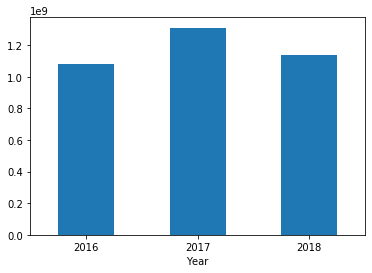

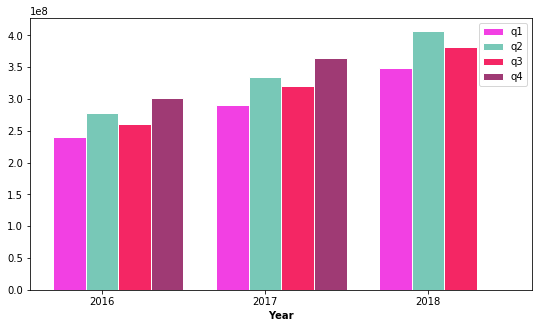

In [ ]:
num=True
count=1
while(num):
    clear_output(wait=True)
    print('Hey!! How can I help you?')
    test_text = input()
    test_text=preprocess(test_text)
    test_text=syn_fun(test_text)
    #print(test_text)
    prod_list,coun_list,year_list,quarter_list=NER(test_text)
    #print(prod_list,coun_list,year_list,quarter_list)
    prod_list_2,coun_list_2,year_list_2,quarter_list_2=list_2(prod_list,coun_list,year_list,quarter_list)
    #print(prod_list,coun_list,year_list,quarter_list)
    try:
        prod_list_2,coun_list_2,year_list_2,quarter_list_2=spell_check(prod_list_2,coun_list_2,year_list_2,quarter_list_2)
        #print(prod_list,coun_list,year_list,quarter_list)
        year_list_2=vly(year_list_2)
        m5=check(prod_list_2,coun_list_2,year_list_2,quarter_list_2)
        #print(m5)
        if(m5==False):
            raise Exception()
        try:
            c=DE(prod_list_2,coun_list_2,year_list_2,quarter_list_2)
            c=[list(i) for i in c]
            for i in range(len(c)):
                if(c[i][2]!=''):
                    c[i][2]=int(c[i][2])
            c=[tuple(i) for i in c]
            if('qtd sales' in test_text):
                c=QTD(c)
            if('mat sales' in test_text):
                c=MAT(c)
            #print(c)
            total_df=DataEngine(c)
            #print(total_df)
            print(data.loc[total_df.index])
            print('Total sales is',total_df['US$ MNF'].sum(),'$')
            l=temp(total_df)
            plot1(l,total_df) #-----------display plot1
            #plt.savefig(output_path+'/plot1.png') # save plot1 as img
            if(len(l)>1):
                x2=plot2(l,total_df)
                d=dic(x2)
                preprocess_dict(d,l) #------------display plot2
            if('average sales' in test_text):
                print('Average sales is',total_df['US$ MNF'].mean(),'$')
        except Exception:
            print('This combination does not exist')
    except Exception:
        print("OUT OF CONTEXT QUESTION: Apologies.. I don't understand your question !!")
    ques=input('Do you have any more questions(y/n): ').lower()
    if(ques=='y'):
        num=True
        count=count+1
    else:
        num=False

In [ ]:
# What are the total sales of Prod2 in USA in Q1 2018 ?        simple

# 1. What are the total sales of Prd2 in USA in Q1 2018?            Handling spelling mistakes
# 2. What are the total sales of Prod2 in USA?                   Asking for missing entity
# 3. What are the total sales of Prod1 in UK in Q4 2018 ?        Handling of error when data is not present
# 4. random text                                                   error
# 5. What is the sales of Prod2 in USA in 2016 to 2018?            range
# 6. What are the total sales of Prd2 in 2018?                  multiple visualizations
# 7. what is the QTD sales of prd1 in USA?
# 8. what is the MAT sales of Prd1 in canada in Q1 2017?


# 9. What are the average sales of Prd2 in canada in Q1 2018?